In [20]:
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
train = pd.read_csv('../data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5197 non-null   float64
 1   volatile acidity      5197 non-null   float64
 2   citric acid           5197 non-null   float64
 3   residual sugar        5197 non-null   float64
 4   chlorides             5197 non-null   float64
 5   free sulfur dioxide   5197 non-null   float64
 6   total sulfur dioxide  5197 non-null   float64
 7   density               5197 non-null   float64
 8   pH                    5197 non-null   float64
 9   sulphates             5197 non-null   float64
 10  alcohol               5197 non-null   float64
 11  quality               5197 non-null   int64  
 12  type_num              5197 non-null   int64  
 13  alc-sug               5197 non-null   float64
 14  qua-sug               5197 non-null   float64
dtypes: float64(13), int64

In [7]:
X = train.drop(columns=['quality'])  
y = train['quality']  

oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

In [11]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15799 entries, 0 to 15798
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         15799 non-null  float64
 1   volatile acidity      15799 non-null  float64
 2   citric acid           15799 non-null  float64
 3   residual sugar        15799 non-null  float64
 4   chlorides             15799 non-null  float64
 5   free sulfur dioxide   15799 non-null  float64
 6   total sulfur dioxide  15799 non-null  float64
 7   density               15799 non-null  float64
 8   pH                    15799 non-null  float64
 9   sulphates             15799 non-null  float64
 10  alcohol               15799 non-null  float64
 11  type_num              15799 non-null  int64  
 12  alc-sug               15799 non-null  float64
 13  qua-sug               15799 non-null  float64
 14  quality               15799 non-null  int64  
dtypes: float64(13), int

In [12]:
X=df_balanced.drop(columns=['quality'])
y=df_balanced['quality']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [27]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier())
])

logistic_params = {
    'classifier': [LogisticRegression(max_iter=1000, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}

random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__max_features': [1,2,3],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None,2, 3, 4],    
}

svm_param = {
    'classifier': [svm.SVC()],
    'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
    
}
gradient_boosting_params = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [50, 100,150, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
}

knn_params = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [3, 5, 7],
}

search_space = [
    logistic_params,
    random_forest_params,
    svm_param,
    gradient_boosting_params,
    knn_params
]

In [28]:
clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 5,
                  scoring='accuracy',
                  n_jobs=-1)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2']},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [None, 2, 3, 4],
                          'classifier__max_features': [1, 2, 3],
                          'classifier__n_estimators': [50, 100, 150]},
                         {'classifier': [SVC()],
                          'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100]},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__learning_rate': [0.01, 0.1, 0.2],
                          'classifier__n_estimators': [50, 100, 150, 200]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3, 5, 7]}],
             scoring='accuracy')

In [29]:
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_features=2, n_estimators=150))])
0.911464725270872
{'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__max_features': 2, 'classifier__n_estimators': 150}


In [17]:
final_model= clf.best_estimator_.fit(X_train,y_train)
y_pred = clf.best_estimator_.predict(X_test)

In [30]:
final_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(max_features=2))])

In [31]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [32]:
print("Matriz de Confusión:")
print(cm)
print("\nTasa de Aciertos (Accuracy): {:.2f}%".format(accuracy * 100))

Matriz de Confusión:
[[449   0   0   0   0   0   0]
 [  0 472   0   0   0   0   0]
 [  0   2 398  59   5   0   0]
 [  0   1  95 300  51   1   0]
 [  0   1   1  22 432   0   0]
 [  0   0   0   0   0 435   0]
 [  0   0   0   0   0   0 436]]

Tasa de Aciertos (Accuracy): 92.47%


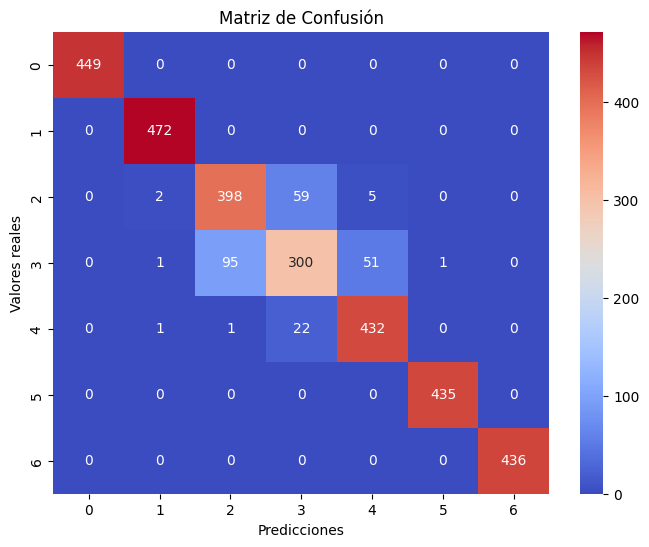

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

- Visualizacion del arbol :

In [25]:
with open('../models/trained_model_1.pkl', 'wb') as archivo_salida :
    pickle.dump(final_model, archivo_salida)

# 2. GRADIANT BOOSTING

In [46]:
train = pd.read_csv('../data/train.csv')


In [47]:
X = train.drop(columns=['quality'])  
y = train['quality']  

oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

In [48]:
X=df_balanced.drop(columns=['quality'])
y=df_balanced['quality']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [50]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', GradientBoostingClassifier())  
])

param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}

gb = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

gb.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [52]:
print(gb.best_estimator_)
print(gb.best_score_)
print(gb.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=5,
                                            n_estimators=150))])
0.9029195135573778
{'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 150}


In [53]:
gb_model= gb.best_estimator_.fit(X_train,y_train)
y_pred2 = gb.best_estimator_.predict(X_test)

In [55]:
cm2 = confusion_matrix(y_test, y_pred2)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Matriz de Confusión:")
print(cm2)
print("\nTasa de Aciertos (Accuracy): {:.2f}%".format(accuracy2 * 100))

Matriz de Confusión:
[[449   0   0   0   0   0   0]
 [  0 472   0   0   0   0   0]
 [  0   8 393  56   7   0   0]
 [  1   5  88 290  62   2   0]
 [  0   0   5  21 429   1   0]
 [  0   0   0   0   0 435   0]
 [  0   0   0   0   0   0 436]]

Tasa de Aciertos (Accuracy): 91.90%


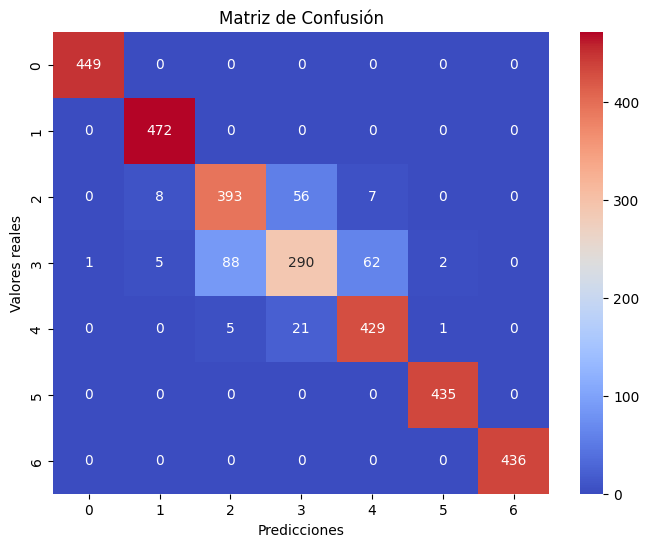

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='g', cmap='coolwarm')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

In [57]:
with open('../models/trained_model_2gb.pkl', 'wb') as archivo_salida :
    pickle.dump(gb_model, archivo_salida)